<a href="https://colab.research.google.com/github/Ayazhannn/mini-projects-python/blob/main/toxic_comment_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries,Data

In [ ]:
!pip install Cmake
!pip install tensorflow gradio pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import gradio as gr
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy


In [ ]:
data = pd.read_csv('/content/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Data analysis

In [ ]:
data.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

In [ ]:
data_count=data.iloc[:,2:].sum()

In [ ]:
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


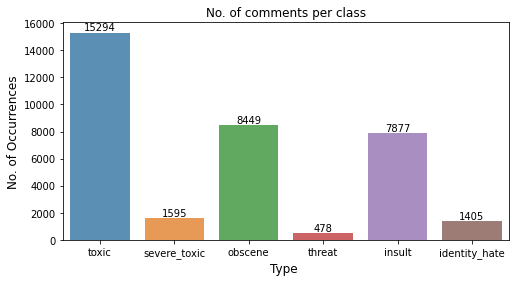

In [ ]:
plt.figure(figsize=(8,4))

ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
num_rows = len(data)
print(num_rows)

159571


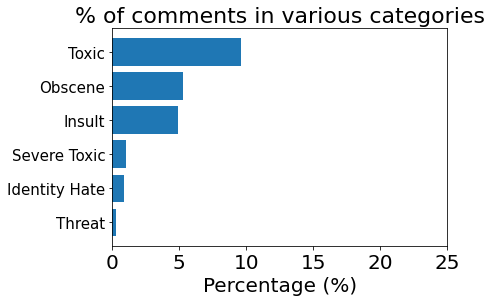

In [ ]:
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100

ind = np.arange(6)

ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

plt.gca().invert_yaxis()
plt.show()


# Preprocess stage

In [ ]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.4.0
aeppl                         0.0.33
aesara                        2.7.9
aiofiles                      23.1.0
aiohttp                       3.8.4
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
bea

In [ ]:
X = data['comment_text']
y = data[data.columns[2:]].values
num_of_words = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens=num_of_words,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))


# Creating model

In [ ]:

model = Sequential()
model.add(Embedding(num_of_words+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='Adam')

history = model.fit(train, epochs=1, validation_data=val,)




6981/6981 [==============================] - 720s 101ms/step - loss: 0.0637 - val_loss: 0.0468


# Evaluating model

In [ ]:
prec = Precision()
rec = Recall()
accuracy = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    prec.update_state(y_true, yhat)
    rec.update_state(y_true, yhat)
    accuracy.update_state(y_true, yhat)

print(f'Precision: {prec.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{accuracy.result().numpy()}')




1/1 [==============================] - 0s 55ms/step
Precision: 0.8552583456039429, Recall:0.6335504651069641, Accuracy:0.47241726517677307


# Gradio app

In [ ]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model.save('toxic_class.h5')
model = tf.keras.models.load_model('toxic_class.h5')

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(data.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

interface = gr.Interface(
    fn=score_comment,title='Toxic comment classifier', inputs=gr.inputs.Textbox(lines=2, placeholder='Your text to check toxicity'),outputs='text',live = True,allow_screenshot=True)
interface.launch(share=True)




/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `allow_screenshot` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c596442a-c654-4d09.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
